In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<h1><a href="https://www.kaggle.com/robervalt/sunspots" target="_blank">太阳黑子预测</a></h1>

In [17]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import mean_absolute_error
from tqdm import tqdm
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time: np.ndarray, series: np.ndarray, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-07-01 15:07:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-07-01 15:07:57 (95.3 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



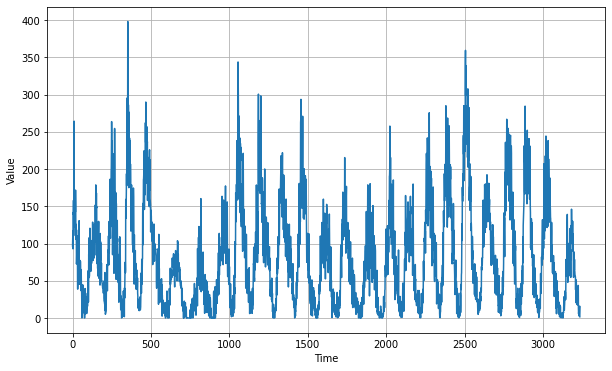

In [5]:
import csv
time_step = []
sunspots = []

with open('../data/sunspots/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series: np.ndarray, window_size: int, batch_size: int, shuffle_buffer: int) -> tf.raw_ops.PrefetchDataset:
    dataset: tf.raw_ops.TensorSliceDataset = Dataset.from_tensor_slices(series)
    dataset: tf.raw_ops.WindowDataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset: tf.raw_ops.FlatMapDataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset: tf.raw_ops.MapDataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset: tf.raw_ops.PrefetchDataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
dataset: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential([
    Dense(units=20, activation="relu", name="dense_1", input_shape=[window_size]), 
    Dense(units=10, activation="relu", name="dense_2"),
    Dense(units=1, activation=None, name="dense_3")
])

model.compile(
    loss="mse",
    optimizer=SGD(lr=1e-7, momentum=0.9)
)

model.fit(
    dataset,
    epochs=100,
    workers=-1,
    use_multiprocessing=True
)


Epoch 1/100
92/92 [==============================] - 0s 3ms/step - loss: 2051.3936
Epoch 2/100
92/92 [==============================] - 0s 3ms/step - loss: 1192.4080
Epoch 3/100
92/92 [==============================] - 0s 2ms/step - loss: 1062.6221
Epoch 4/100
92/92 [==============================] - 0s 3ms/step - loss: 992.1569
Epoch 5/100
92/92 [==============================] - 0s 3ms/step - loss: 933.7087
Epoch 6/100
92/92 [==============================] - 0s 2ms/step - loss: 890.9033
Epoch 7/100
92/92 [==============================] - 0s 2ms/step - loss: 881.7604
Epoch 8/100
92/92 [==============================] - 0s 3ms/step - loss: 845.0448
Epoch 9/100
92/92 [==============================] - 0s 2ms/step - loss: 837.8726
Epoch 10/100
92/92 [==============================] - 0s 2ms/step - loss: 799.7355
Epoch 11/100
92/92 [==============================] - 0s 2ms/step - loss: 788.2638
Epoch 12/100
92/92 [==============================] - 0s 3ms/step - loss: 775.4221
Epoch 13/1

100%|████████████████████████████████████████████████████████████████████████████████| 3175/3175 [01:14<00:00, 42.86it/s]


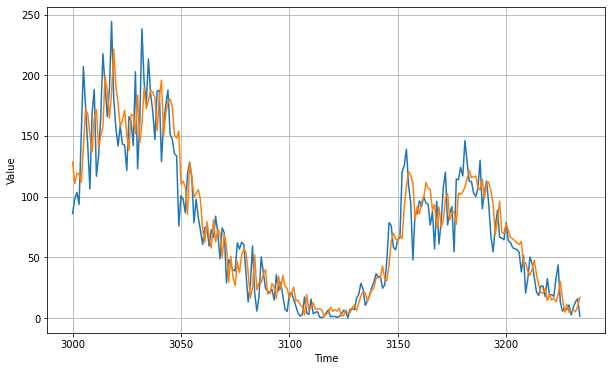

In [16]:
forecast = []
for time in tqdm(range(len(series) - window_size)):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast: [np.ndarray] = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
print(mean_absolute_error(x_valid, results).numpy())

15.695936
